# Study of Flight Delays in 2008
## by Shu Liu

## Investigation Overview

> In this investigation, I will look at the flight delays data and study the relationships between flight delays and various factors such as carrier, airport, flight time as well as flight distance.

## Dataset Overview

> The dataset for this project reports flights in the United States during the year of 2008 with 7,009,728 original records in total, including carriers, airports, arrival and departure delays as well as flight cancellations. After preliminary data wrangling, I added a few data features and removed unusable data records. As a result, the dataset now has 6,753,922 flight records with 32 features.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_2008 = pd.read_csv('2008_clean_master_file.csv')
df_2008.shape

(6753922, 32)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Which airline company has the longest depature/arrival delays?

> United Airlines has the longest average departure delays, and American Airlines has the longest average arrival delays. On the opposite side, flights with Aloha Airlines are advanced on average, and more than 75% of the time Aloha Airlines fly planes earlier than CRS schedule.

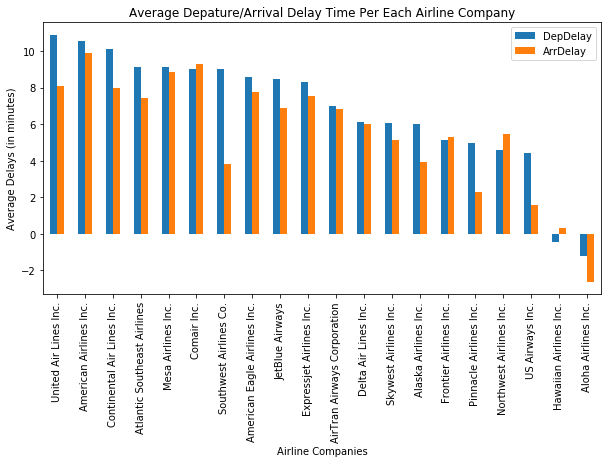

In [3]:
df_airline = df_2008.groupby('carrier_Description').agg({'DepDelay':'mean','ArrDelay':'mean'}).sort_values('DepDelay',ascending=False)
df_airline.plot(kind='bar',figsize=(10,5))
plt.title('Average Depature/Arrival Delay Time Per Each Airline Company')
plt.xlabel('Airline Companies')
plt.ylabel('Average Delays (in minutes)');

## At what hour do people mostly likely to experience the worst flight delays?

> Overall, AM flights experience less delays than PM flights for both departure and arrival.

> From 6AM to 8PM there is a gradual increase in the average departure delay time per hour. I think this is because if there are flights delayed in the previous hour, the flight departure schedule in the next hour will be disrupted as a result. So the flight delay situation will aggregate over time. Then during midnight hours since airports generally schedule less flight departure, the trend goes down evetually.

> There is a similar trend for the arrival time, yet the arrival delay trend is lagged compared to the departure delay trend. I believe this lag is in alignment with time it takes for a plane to fly between two locations. Additionally, flight arrival around 6-7AM tend to be earlier than scheduled.

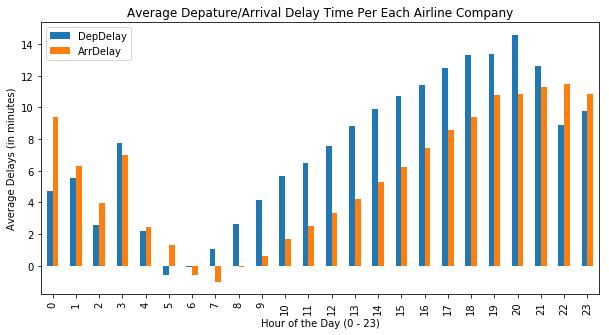

In [4]:
df_dep = df_2008.groupby('CRS_DepHour').agg({'DepDelay':'mean'}).sort_values('CRS_DepHour',ascending=True).reset_index()
df_arr = df_2008.groupby('CRS_ArrHour').agg({'ArrDelay':'mean'}).sort_values('CRS_ArrHour',ascending=True).reset_index()
#df_arr = df_arr[df_arr.index != '24']

df_delays = pd.merge(df_dep,df_arr,left_on='CRS_DepHour',right_on='CRS_ArrHour')
df_delays[['DepDelay','ArrDelay']].plot(kind='bar',figsize=(10,5))
plt.title('Average Depature/Arrival Delay Time Per Each Airline Company')
plt.xlabel('Hour of the Day (0 - 23)')
plt.ylabel('Average Delays (in minutes)');

## What's the biggest reason for departure delay at each airport?

> For most of airline companies, the two biggest reasons for flight delay are late aircraft and NAS (national air system) delay. On the other hand, for airline companies like Comair, Mesa Airlines and Atlantic Southeast Airlines, the top two reasons are carrier delay and weather delay.

> In general, very few delays are caused by security reasons. Appreciate the hardwork by security screening officers!

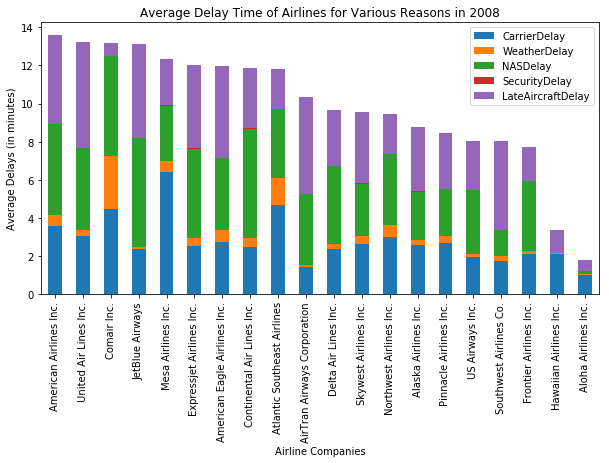

In [5]:
df_airport = df_2008.groupby('carrier_Description').agg({'DepDelay':'mean','CarrierDelay':'mean','WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'})
df_airport['total'] = df_airport.iloc[:,1:6].sum(axis=1)
df_airport = df_airport.sort_values('total', ascending=False)
df_airport[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']].plot(kind="bar",stacked=True,figsize=(10,5)).set_title('Average Delay Time of Airlines for Various Reasons in 2008')
plt.xlabel('Airline Companies')
plt.ylabel('Average Delays (in minutes)');

## What do the delays typically look like for different flight distance?
> Short distance flights have the largest numbr of delays, while medium distance flight has the highest portion of delays out of all flights.

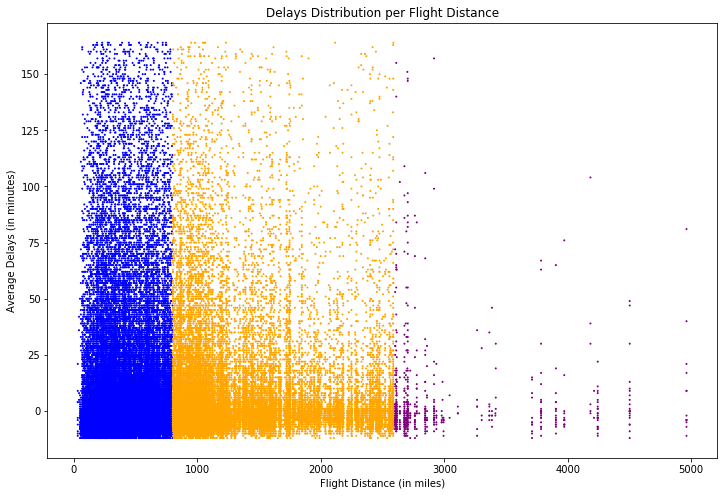

In [6]:
plt.figure(figsize=(12,8))
data=df_2008.sample(100000).sort_values(by='FlightLen',ascending=False)
colors = {'Short haul':'blue', 'Medium haul':'orange', 'Long haul':'purple'}
plt.scatter(x=data['Distance'],y=data['DepDelay'],c=data['FlightLen'].map(colors),s=1)
plt.title('Delays Distribution per Flight Distance')
plt.xlabel('Flight Distance (in miles)')
plt.ylabel('Average Delays (in minutes)');

In [7]:
delay = df_2008.query('DepDelay>0').groupby(['FlightLen'])['DepDelay'].agg([('Count of Delayed Flights','count')]).reset_index()
total = df_2008.groupby(['FlightLen'])['DepDelay'].agg([('Total Count of Flights','count')]).reset_index()
delay = pd.merge(left=delay,right=total,left_on='FlightLen',right_on='FlightLen')
delay['Delay Ratio %'] = np.round(delay['Count of Delayed Flights']/delay['Total Count of Flights']*100,2)
print('Percent of Flight Delays for Different Flight Length:\n',delay[['FlightLen','Count of Delayed Flights','Delay Ratio %']]);

Percent of Flight Delays for Different Flight Length:
      FlightLen  Count of Delayed Flights  Delay Ratio %
0    Long haul                     17273          40.96
1  Medium haul                    966446          42.87
2   Short haul                   1649409          37.00


## What do flight delays look like on a map?
> Average departure and arrival delays of each airport on a heatmap in the shape of US map. Each dot represents the approximation of the location of an airport. The warmer ('reder) the color, the more delayed departure/arrival is a flight on average in that airport.

In [8]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

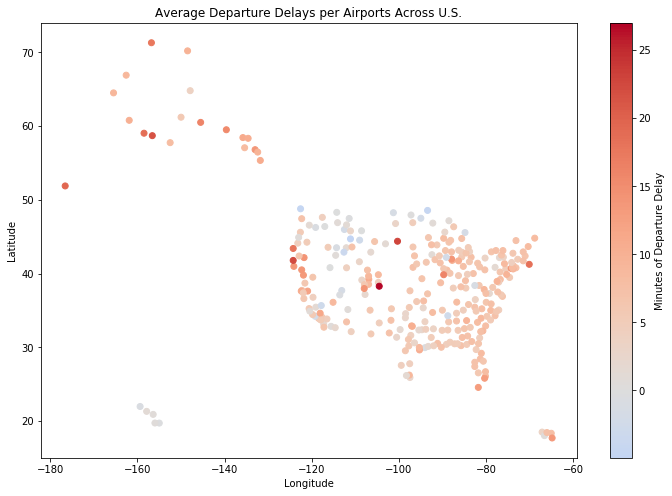

In [9]:
df_delay = df_2008.groupby('Origin').agg({'DepDelay':'mean','Origin_long':'mean','Origin_lat':'mean'}).reset_index()

plt.figure(figsize=(12,8))
vmin = df_delay.DepDelay.min()
vmax = df_delay.DepDelay.max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
cmap = plt.get_cmap('coolwarm')

g = plt.scatter(x=df_delay.Origin_long,y=df_delay.Origin_lat,c=df_delay.DepDelay,cmap=cmap,norm=norm)
plt.colorbar(g).set_label('Minutes of Departure Delay')
plt.title('Average Departure Delays per Airports Across U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [10]:
print('Top 5 airports that experience the longest departure delays on average:\n',df_delay.sort_values(by='DepDelay',ascending=False)[['Origin','DepDelay']][:5])

Top 5 airports that experience the longest departure delays on average:
     Origin   DepDelay
232    PUB  27.000000
223    PIR  22.800000
54     CEC  22.314534
12     AKN  21.532110
8      ADK  19.582278


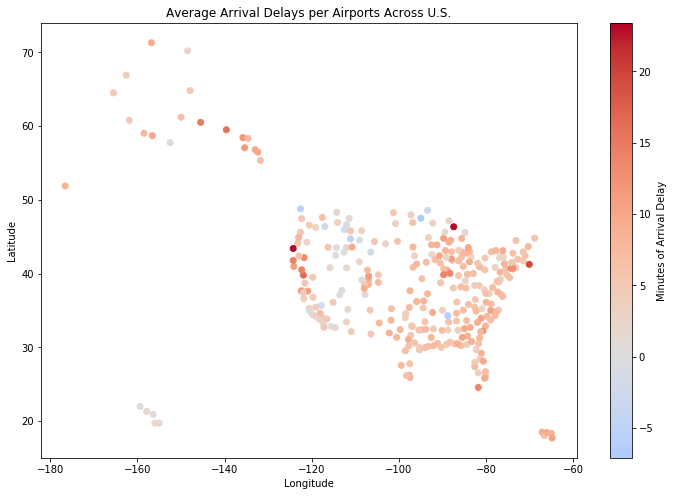

In [11]:
df_delay = df_2008.groupby('Dest').agg({'ArrDelay':'mean','Dest_long':'mean','Dest_lat':'mean'}).reset_index()

plt.figure(figsize=(12,8))
vmin = df_delay.ArrDelay.min()
vmax = df_delay.ArrDelay.max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
cmap = plt.get_cmap('coolwarm')

g = plt.scatter(x=df_delay.Dest_long,y=df_delay.Dest_lat,c=df_delay.ArrDelay,cmap=cmap,norm=norm)
plt.colorbar(g).set_label('Minutes of Arrival Delay')
plt.title('Average Arrival Delays per Airports Across U.S.')
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [12]:
print('Top 5 airports that experience the longest arrival delays on average:\n',df_delay.sort_values(by='ArrDelay',ascending=False)[['Dest','ArrDelay']][:5])

Top 5 airports that experience the longest arrival delays on average:
     Dest   ArrDelay
196  MQT  23.398487
214  OTH  23.100823
4    ACK  19.720657
58   CIC  16.481231
301  YAK  15.784672


## The End

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [18]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'slide_deck.ipynb'])

#!jupyter nbconvert slide_deck.ipynb --to slides --post serve --template output_toggle